## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(25836, 57)

In [12]:
privileged_groups

[{'age': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[  1.  89.   1. ...   0.   1.   0.]
 [  1.  56.   3. ...   0.   1.   0.]
 [  1. 135.   1. ...   0.   1.   0.]
 ...
 [  1. 154.   3. ...   0.   1.   0.]
 [  1. 122.   2. ...   0.   1.   0.]
 [  1.  75.   3. ...   0.   1.   0.]]


In [14]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights            features                           \
                                protected attribute                            
                                                age duration campaign  pdays   
instance names                                                                 
18029                       1.0                 1.0     89.0      1.0  999.0   
17857                       1.0                 1.0     56.0      3.0  999.0   
17772                       1.0                 1.0    135.0      1.0  999.0   
14332                       1.0                 1.0    512.0      3.0  999.0   
4620                        1.0                 1.0    246.0      3.0  999.0   
...                         ...                 ...      ...      ...    ...   
952                         1.0                 1.0    516.0      1.0  999.0   
20561                       1.0                 1.0    226.0      4.0  999.0   
38614                       1.0         

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [17]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[1.00e+00 3.66e+02 1.00e+00 ... 0.00e+00 1.00e+00 0.00e+00]
 [1.00e+00 1.06e+03 2.00e+00 ... 0.00e+00 1.00e+00 0.00e+00]
 [1.00e+00 8.09e+02 6.00e+00 ... 0.00e+00 1.00e+00 0.00e+00]
 ...
 [1.00e+00 7.60e+01 1.00e+00 ... 0.00e+00 1.00e+00 0.00e+00]
 [1.00e+00 1.49e+02 1.00e+00 ... 0.00e+00 1.00e+00 0.00e+00]
 [1.00e+00 1.34e+02 2.00e+00 ... 0.00e+00 1.00e+00 0.00e+00]]
no bias type specified
#### Training Dataset shape
(12918, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 147
Number of test samples (ntest): 148
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1155
Number of test samples (ntest): 1122
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.7621400520468967
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11616, Test = 11648
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.747214401830221
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of 

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1155
Number of test samples (ntest): 1122
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6999731456303452
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11616, Test = 11648
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.03
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -1.0296194171811583
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1302, Test = 1270
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.69


Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1155
Number of test samples (ntest): 1122
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -0.6466271649250525
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11616, Test = 11648
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.6466271649250525
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1302, Test = 1270
  AUC: 0.68
  Privacy Risk: 0.63
  Accuracy: 0.64
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.54


Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 147
Number of test samples (ntest): 148
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1155
Number of test samples (ntest): 1122
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.47859318667549333
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11616, Test = 11648
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.38440684833378913
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.02  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.03  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.04  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.05  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.060000000000000005  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.06999999999999999  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.08  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.09  is: 0.09173246632605667
Balanced accuracy is:  0.3318378471921779
Accuracy for threshold: 0.09999999999999999  is: 0.09173246632605667
Balanced accuracy is:  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       424
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97       424
   macro avg       0.50      0.49      0.49       424
weighted avg       1.00      0.97      0.99       424

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.69      0.82       147

    accuracy                           0.69       147
   macro avg       0.50      0.35      0.41       147
weighted avg       1.00      0.69      0.82       147

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     11192
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98     11192
   macro avg       0.50   

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5254
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.3287
Corresponding statistical parity difference value: 0.2431
Corresponding equal opportunity difference value: 0.4932
Corresponding Theil index value: 0.0997
Corresponding false positive_rate for privileged: 0.0000
Corresponding false negative_rate for privileged: 1.0000
Corresponding false positive_rate for unpribileged: 0.1642
Corresponding false negative_rate for unprivileged: 0.5068
#### Train dataset's features are as below:
[[  1. 101.   5. ...   0.   1.   0.]
 [  0. 178.   2. ...   0.   1.   0.]
 [  1. 417.   3. ...   0.   1.   0.]
 ...
 [  1. 359.   5. ...   0.   1.   0.]
 [  1. 207.   1. ...   0.   1.   0.]
 [  1. 453.   1. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(12918, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.7006943861953283
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6931471805599453
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.7472144018302211
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.5925036547802578
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.53


Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -1.0608719606852628
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.0116009116784799
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.02  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.03  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.04  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.05  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.060000000000000005  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.06999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.08  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93       444
         1.0       0.00      0.00      0.00         0

    accuracy                           0.86       444
   macro avg       0.50      0.43      0.46       444
weighted avg       1.00      0.86      0.93       444

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.32      0.49       149

    accuracy                           0.32       149
   macro avg       0.50      0.16      0.24       149
weighted avg       1.00      0.32      0.49       149

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     11179
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96     11179
   macro avg       0.50   

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.04984180047957301
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.64
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5184
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.2454
Corresponding statistical parity difference value: 0.1872
Corresponding equal opportunity difference value: 0.3624
Corresponding Theil index value: 0.1029
Corresponding false positive_rate for privileged: 0.0000
Corresponding false negative_rate for privileged: 1.0000
Corresponding false positive_rate for unpribileged: 0.1284
Corresponding false negative_rate for unprivileged: 0.6376
#### Train dataset's features are as below:
[[  1. 101.   5. ...   0.   1.   0.]
 [  0. 178.   2. ...   0.   1.   0.]
 [  1. 417.   3. ...   0.   1.   0.]
 ...
 [  1. 359.   5. ...   0.   1.   0.]
 [  1. 207.   1. ...   0.   1.   0.]
 [  1. 453.   1. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(12918, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 449
Number of test samples (ntest): 444
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.7006943861953283
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predicti

Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.7472144018302211
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.5925036547802578
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.53


Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -1.0608719606852628
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.0116009116784799
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.61
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.36


Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.6577596562482995
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.67
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.51


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.02  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.03  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.04  is: 0.0913454095061155
Balanced accuracy is:  0.37737570660224024
Accuracy for threshold: 0.05  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.060000000000000005  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.06999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.08  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09  is: 0.0915776435980802
Balanced accuracy is:  0.3404518799597523
Accuracy for threshold: 0.09999999999999999  is: 0.0915776435980802
Balanced accuracy is:  0.3404

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     11179
         1.0       0.00      0.00      0.00         0

    accuracy                           0.96     11179
   macro avg       0.50      0.48      0.49     11179
weighted avg       1.00      0.96      0.98     11179

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.45      0.62      1146

    accuracy                           0.45      1146
   macro avg       0.50      0.22      0.31      1146
weighted avg       1.00      0.45      0.62      1146

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 449
Number of test samples (ntest): 444
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 146
Number of test samples (ntest): 149
Protected_attr_val, label, 1.0 0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Number of training samples (ntrain): 11192
Number of test samples (ntest): 11179
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1131
Number of test samples (ntest): 1146
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 12918, Test = 12918
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -0.04984180047957301
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 11641, Test = 11623
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1277, Test = 1295
  AUC: 0.64
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [18]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [19]:
df_bank['age'].value_counts()

age
1.0    24648
0.0     1188
Name: count, dtype: int64

In [20]:
# Count the occurrences of privileged and unprivileged values
age_counts = df_bank['age'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Age')
plt.xlabel('Age Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

C:\Users\ilham\AppData\Local\Temp\ipykernel_16156\3099988083.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [21]:
y_counts = df_bank['y'].value_counts()

In [22]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

C:\Users\ilham\AppData\Local\Temp\ipykernel_16156\3133446903.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [23]:
df_bank.shape

(25836, 58)

## Display Output

In [24]:
priv_metric_orig_copy = priv_metric_orig

In [25]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 36993.0, 'total_unpriv': 1761.0})

In [26]:
priv_metric_orig

defaultdict(float, {'total_priv': 36993.0, 'total_unpriv': 1761.0})

In [27]:
priv_metric_orig = priv_metric_orig_copy

1)

bank
12918
2)

              total_priv  total_unpriv
num_instance                          
orig             12331.0         587.0
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.099499       0.900501    0.092368      0.907632      0.249400   
transf      0.092369       0.907631    0.092368      0.907632      0.092371   

         unpriv_unfavor  
dataset                  
orig           0.750600  
transf         0.907629  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.831272       0.098078  0.555092       0.259836   
dt_syn                     0.701941      -0.058495  0.441393       0.067538   
dt_dir                     0.818946       0.095083  0.602322       0.282108   
dt_rew                     0.824024     

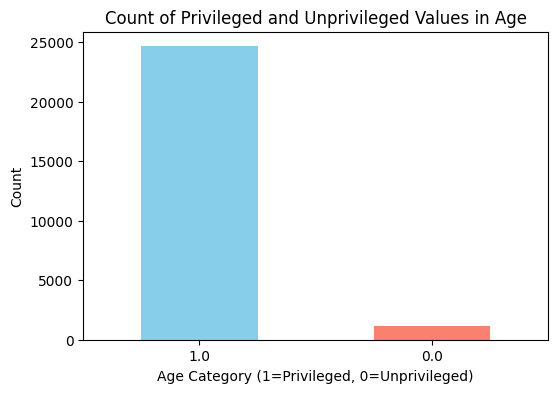

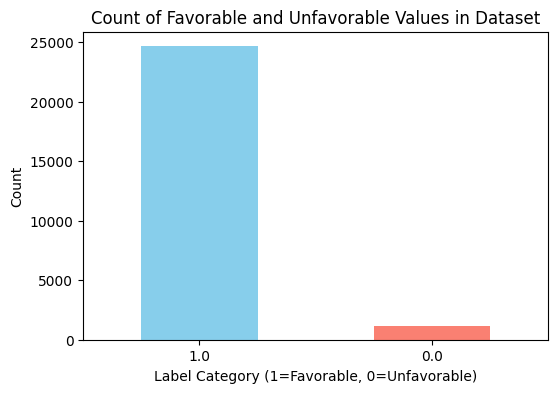

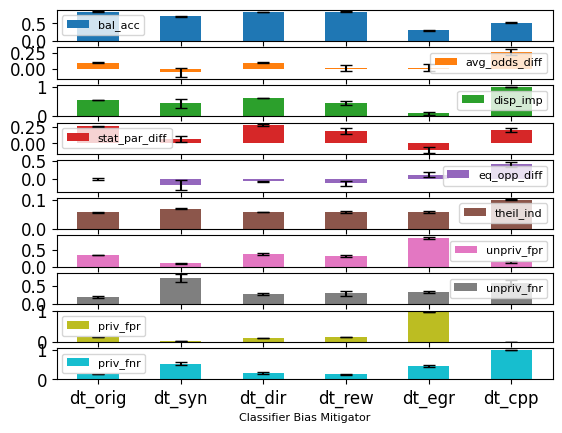

In [28]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

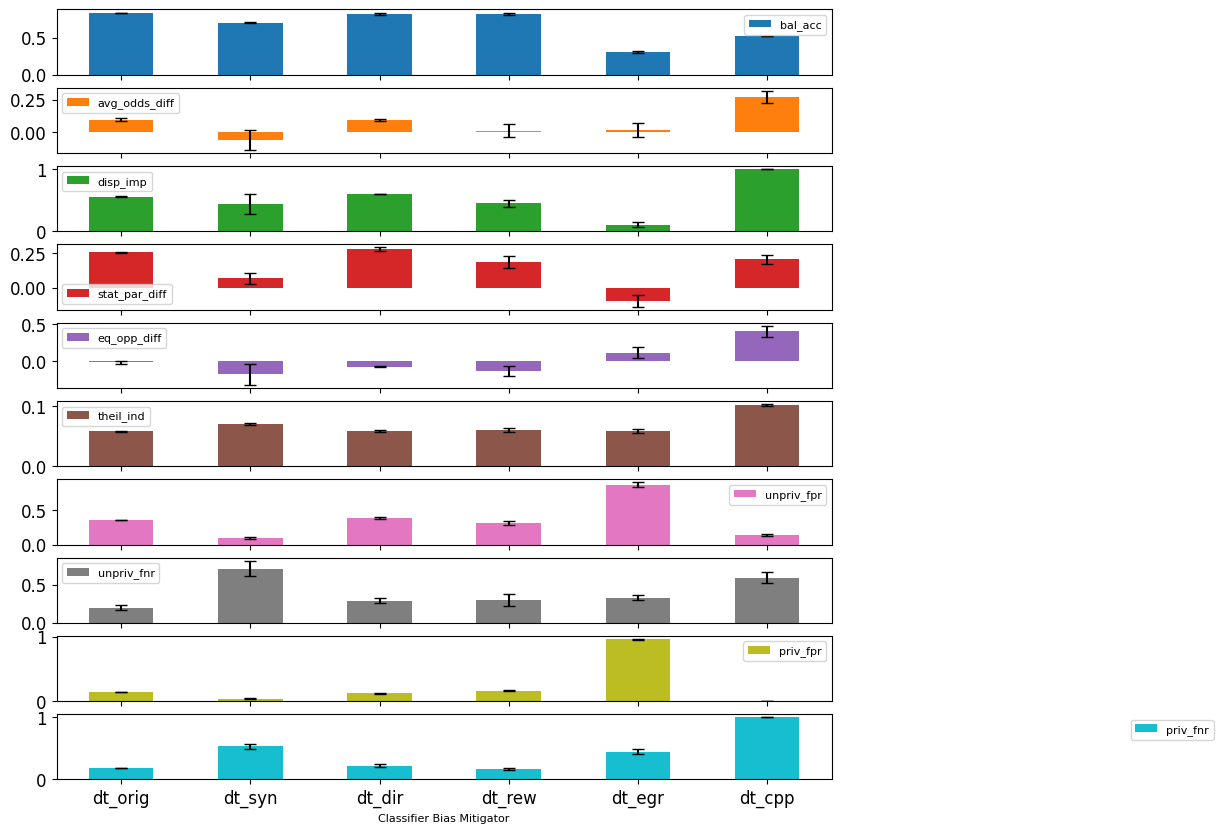

In [29]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [30]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.831272,0.098078,0.555092,0.259836,-0.015959,0.057924,0.358222,0.197231,0.146107,0.181272
dt_syn,0.701941,-0.058495,0.441393,0.067538,-0.177845,0.070609,0.099230,0.712740,0.038376,0.534895
dt_dir,0.818946,0.095083,0.602322,0.282108,-0.073666,0.059075,0.389424,0.291402,0.125593,0.217736
dt_rew,0.824024,0.011790,0.450462,0.187094,-0.130277,0.060346,0.317051,0.298008,0.163193,0.167731
dt_egr,0.303994,0.016360,0.105680,-0.097747,0.116737,0.058977,0.876265,0.331761,0.960283,0.448498
dt_cpp,0.520743,0.273169,1.000000,0.205826,0.406025,0.101823,0.140312,0.593975,0.000000,1.000000


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [31]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [32]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.523211,0.512881,0.616542,0.561247,0.671550,0.511190,0.611296
syn,0.515856,0.508251,0.586089,0.551344,0.609639,0.506881,0.584418
dir,0.527365,0.517318,0.621991,0.590445,0.680583,0.514720,0.616484
rew,0.522307,0.511713,0.619460,0.557257,0.667037,0.510034,0.615882
egr,0.525765,0.515451,0.624156,0.587070,0.688328,0.512544,0.625816


In [33]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [34]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [35]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.561247,0.671550,0.511190,0.611296
syn,0.551344,0.609639,0.506881,0.584418
dir,0.590445,0.680583,0.514720,0.616484
rew,0.557257,0.667037,0.510034,0.615882
egr,0.587070,0.688328,0.512544,0.625816


<Axes: xlabel='Classifier MIA Attacks'>

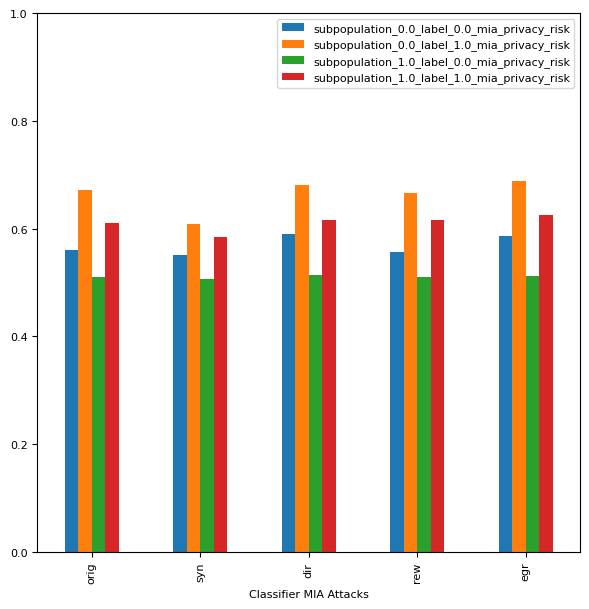

In [36]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [37]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.561247  0.551344  0.590445  0.557257  0.58707
subpopulation_0.0_label_1.0_mia_privacy_risk  0.67155   0.609639  0.680583  0.667037  0.688328
subpopulation_1.0_label_0.0_mia_privacy_risk  0.51119   0.506881  0.51472   0.510034  0.512544
subpopulation_1.0_label_1.0_mia_privacy_risk  0.611296  0.584418  0.616484  0.615882  0.625816


### Visualizing using novel technique

In [38]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [39]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [40]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.522024
1,orig,entire_dataset_mia_privacy_risk,0.523804
2,orig,entire_dataset_mia_privacy_risk,0.523804
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.512466
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.513088
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.632124
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.622663


In [41]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.522024
1,orig,entire_dataset_mia_privacy_risk,0.523804
2,orig,entire_dataset_mia_privacy_risk,0.523804
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.556838
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.563452
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512813
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.632124
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.622663


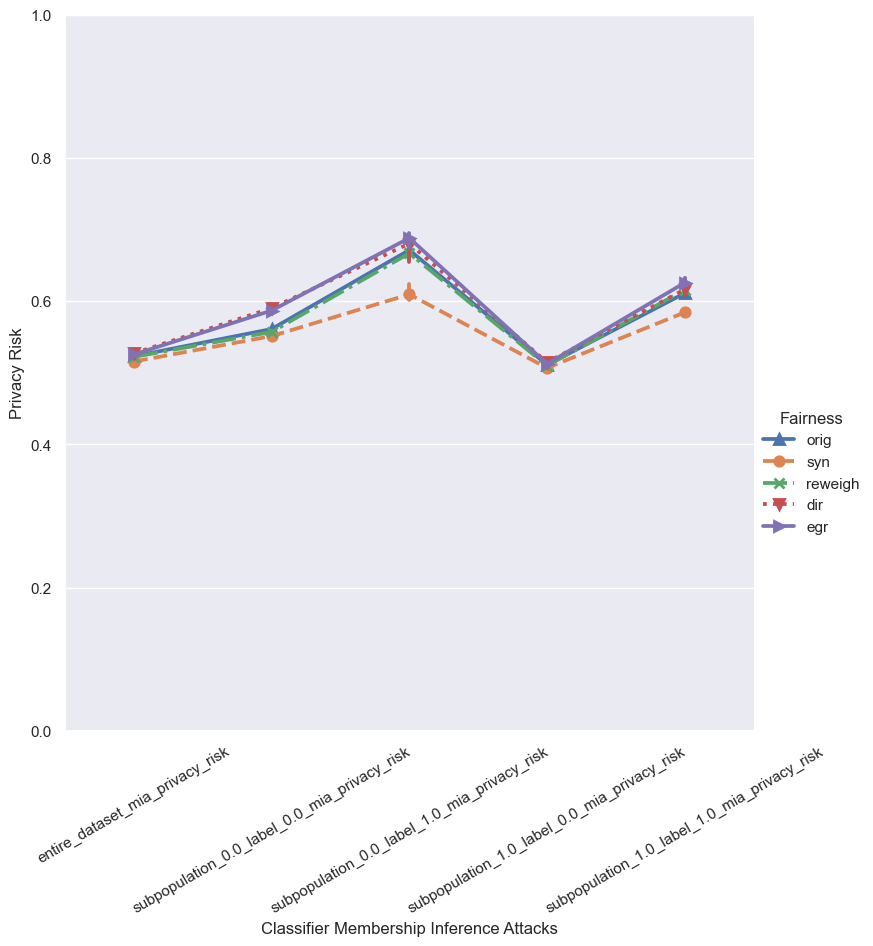

In [42]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [43]:
from sklearn.metrics import RocCurveDisplay, auc

In [44]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

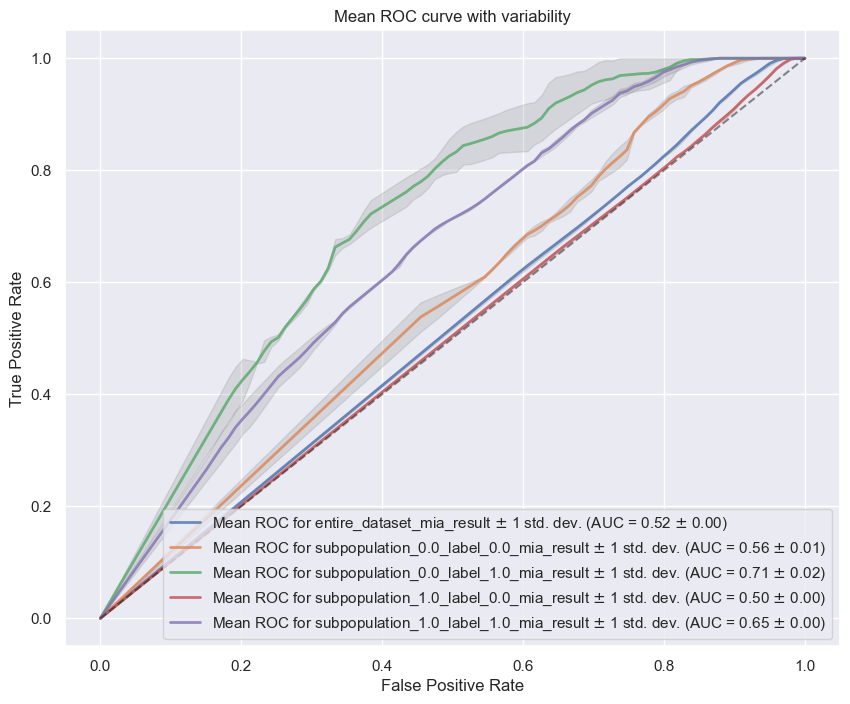

In [45]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

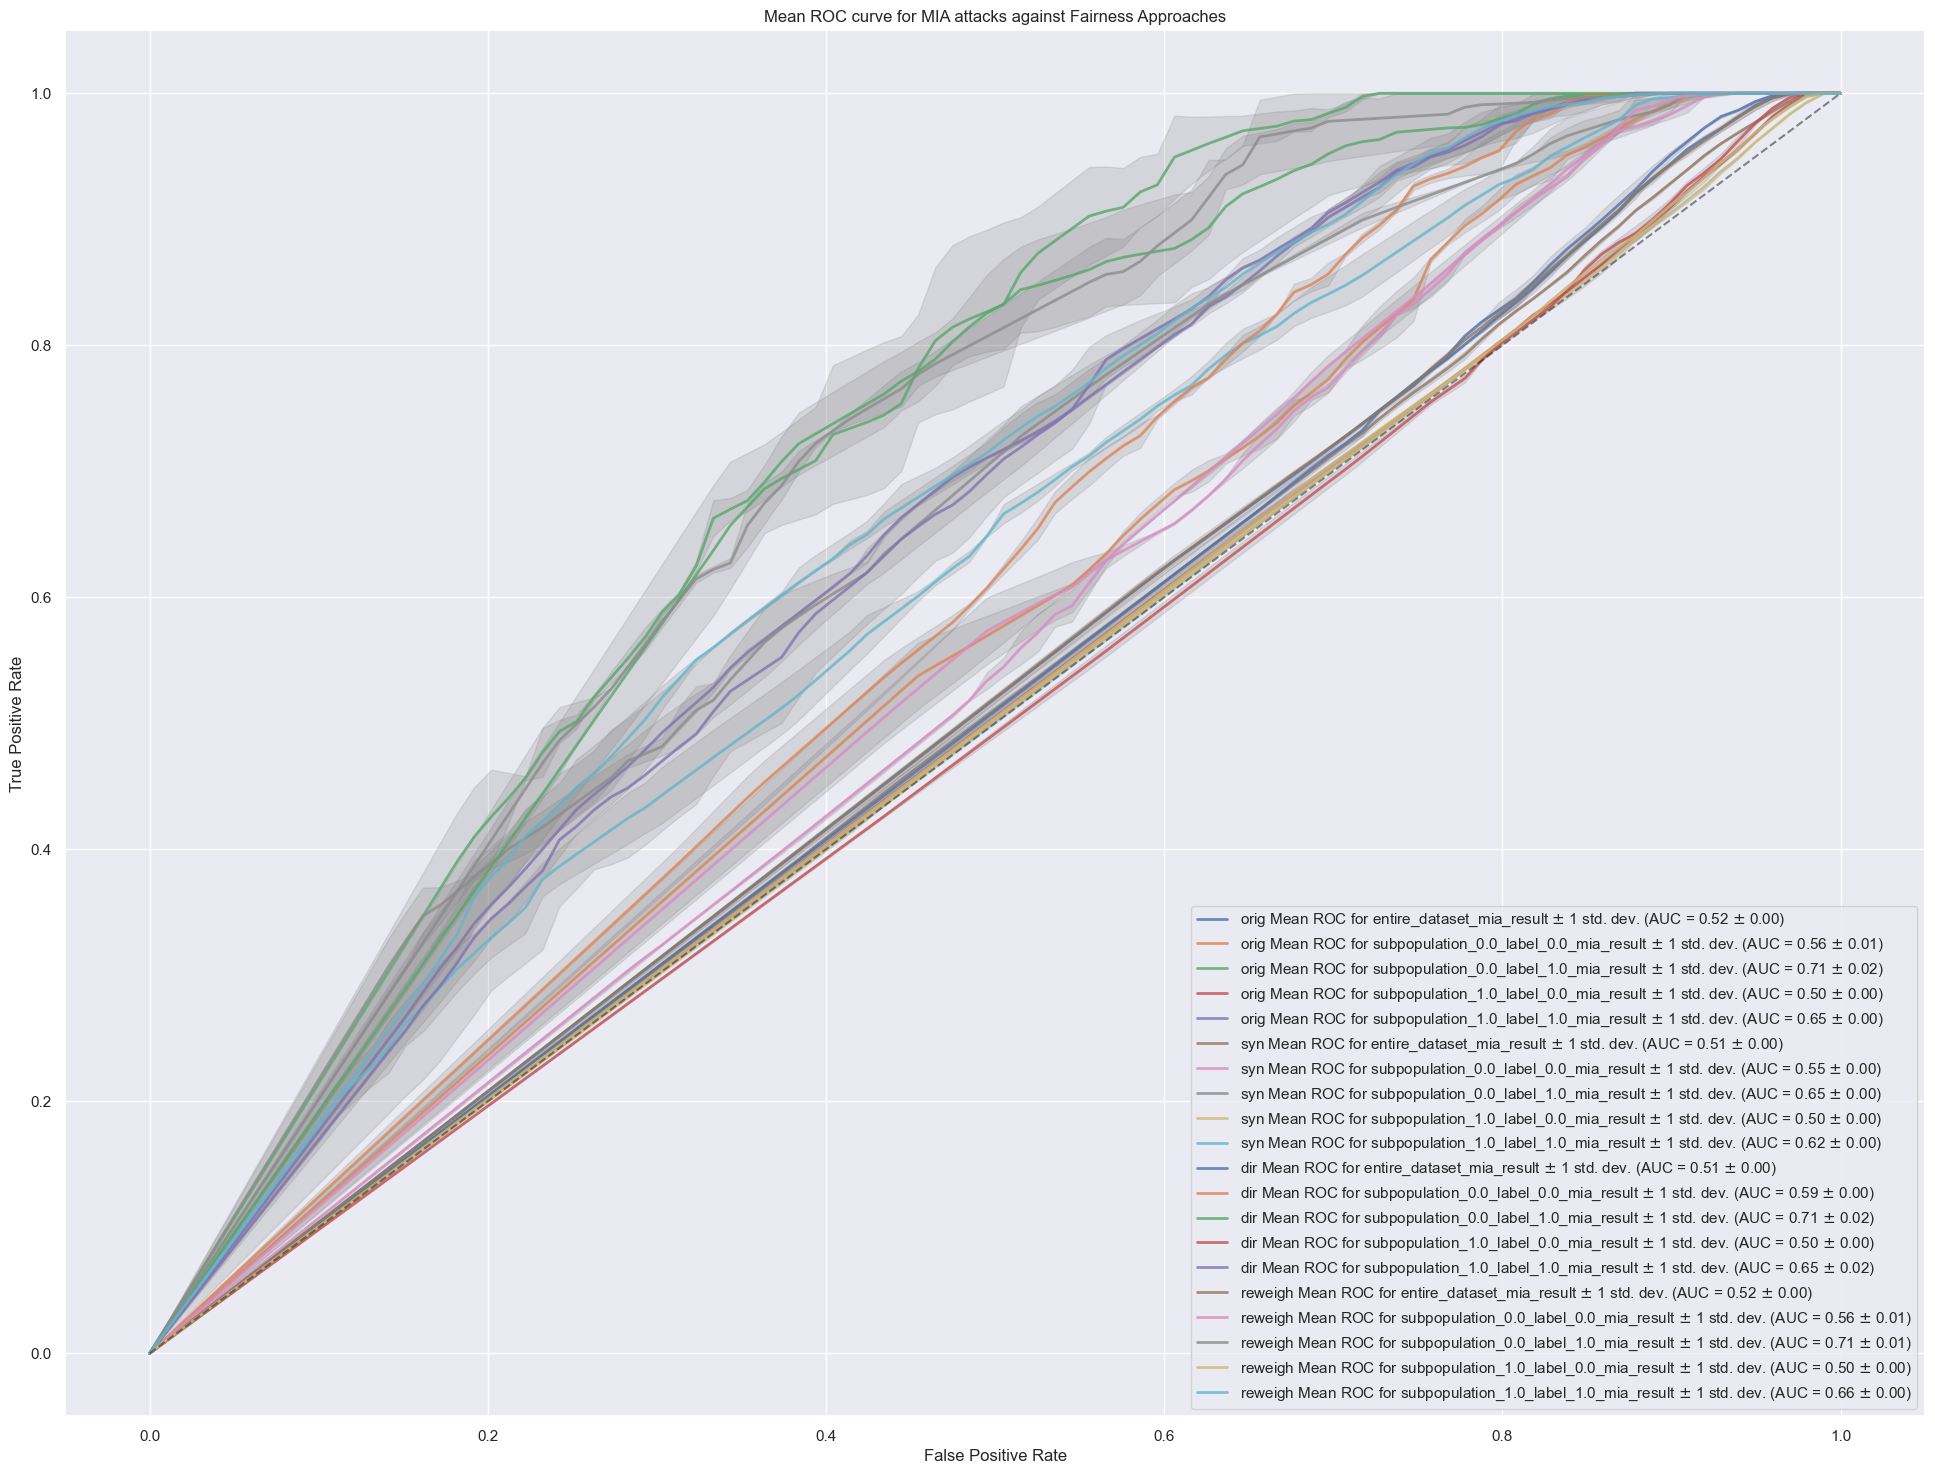

In [46]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

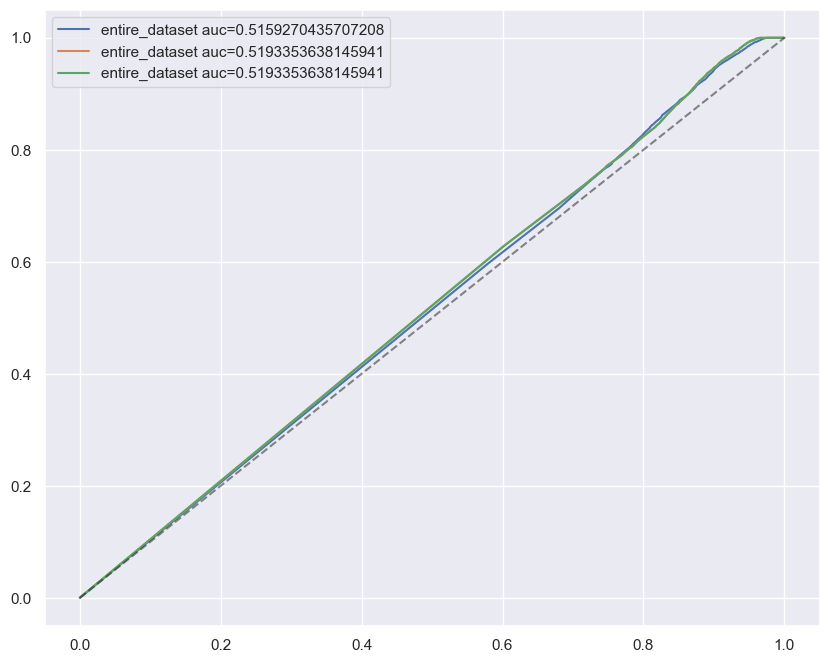

In [47]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [48]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("mia_auc")}

In [49]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5181992570666364,
 'entire_dataset_label_0.0_mia_auc': 0.5070560153629758,
 'entire_dataset_label_1.0_mia_auc': 0.6601576330913828,
 'subpopulation_0.0_label_0.0_mia_auc': 0.562517658289874,
 'subpopulation_0.0_label_1.0_mia_auc': 0.711526349990212,
 'subpopulation_1.0_label_0.0_mia_auc': 0.5049345816574667,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6533092398373396}

In [50]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.518199,0.507056,0.660158,0.562518,0.711526,0.504935,0.653309
syn,0.511384,0.503605,0.622751,0.545506,0.654825,0.502277,0.618189
dir,0.514728,0.502437,0.657643,0.594873,0.714828,0.498681,0.648455
rew,0.518579,0.506844,0.667386,0.556495,0.708500,0.504893,0.661996
egr,0.526472,0.515611,0.646123,0.587561,0.719631,0.512714,0.640026


<Axes: xlabel='Classifier MIA Attacks'>

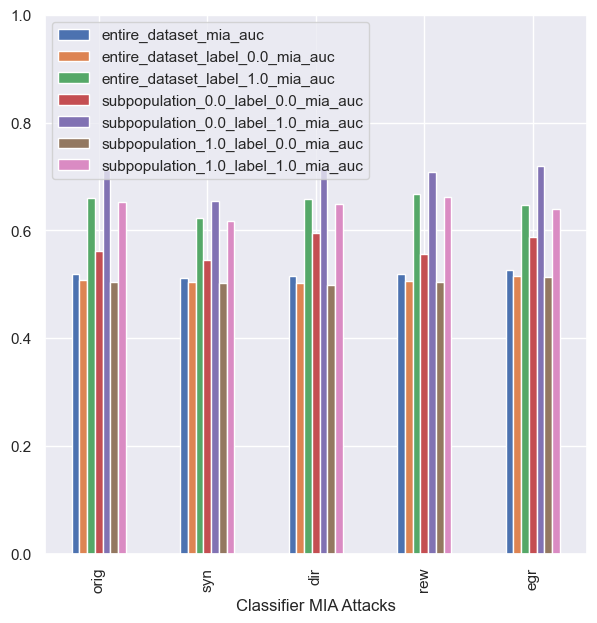

In [51]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [52]:
# Creating data structures to plot point categorical plot from seaborn

In [53]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [54]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.044047066109304756,
  0.047607988852763516,
  0.047607988852763516],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.024932690415644942,
  0.026176855068540394,
  0.026176855068540394],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.2268901871137075,
  0.2361815669568214,
  0.2361815669568214],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.11367522227139226,
  0.12690362968759406,
  0.12690362968759406],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.31522338665195804,
  0.3570377861542705,
  0.3570377861542705],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.021309764280915466,
  0.022915458315240667,
  0.022915458315240667],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.22182327476445124,
  0.22297600696228614,
  0.22297600696228614]}

In [55]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.044047066109304756],
 ['orig', 'entire_dataset', 0.047607988852763516],
 ['orig', 'entire_dataset', 0.047607988852763516],
 ['orig', 'entire_dataset_label_0.0', 0.024932690415644942],
 ['orig', 'entire_dataset_label_0.0', 0.026176855068540394],
 ['orig', 'entire_dataset_label_0.0', 0.026176855068540394],
 ['orig', 'entire_dataset_label_1.0', 0.2268901871137075],
 ['orig', 'entire_dataset_label_1.0', 0.2361815669568214],
 ['orig', 'entire_dataset_label_1.0', 0.2361815669568214],
 ['orig', 'subpopulation_0.0_label_0.0', 0.11367522227139226],
 ['orig', 'subpopulation_0.0_label_0.0', 0.12690362968759406],
 ['orig', 'subpopulation_0.0_label_0.0', 0.12690362968759406],
 ['orig', 'subpopulation_0.0_label_1.0', 0.31522338665195804],
 ['orig', 'subpopulation_0.0_label_1.0', 0.3570377861542705],
 ['orig', 'subpopulation_0.0_label_1.0', 0.3570377861542705],
 ['orig', 'subpopulation_1.0_label_0.0', 0.021309764280915466],
 ['orig', 'subpopulation_1.0_label_0.0', 0.0229

In [56]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.044047
1,orig,entire_dataset,0.047608
2,orig,entire_dataset,0.047608
3,orig,entire_dataset_label_0.0,0.024933
4,orig,entire_dataset_label_0.0,0.026177
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.025625
101,egr,subpopulation_1.0_label_0.0,0.025625
102,egr,subpopulation_1.0_label_1.0,0.264248
103,egr,subpopulation_1.0_label_1.0,0.245326


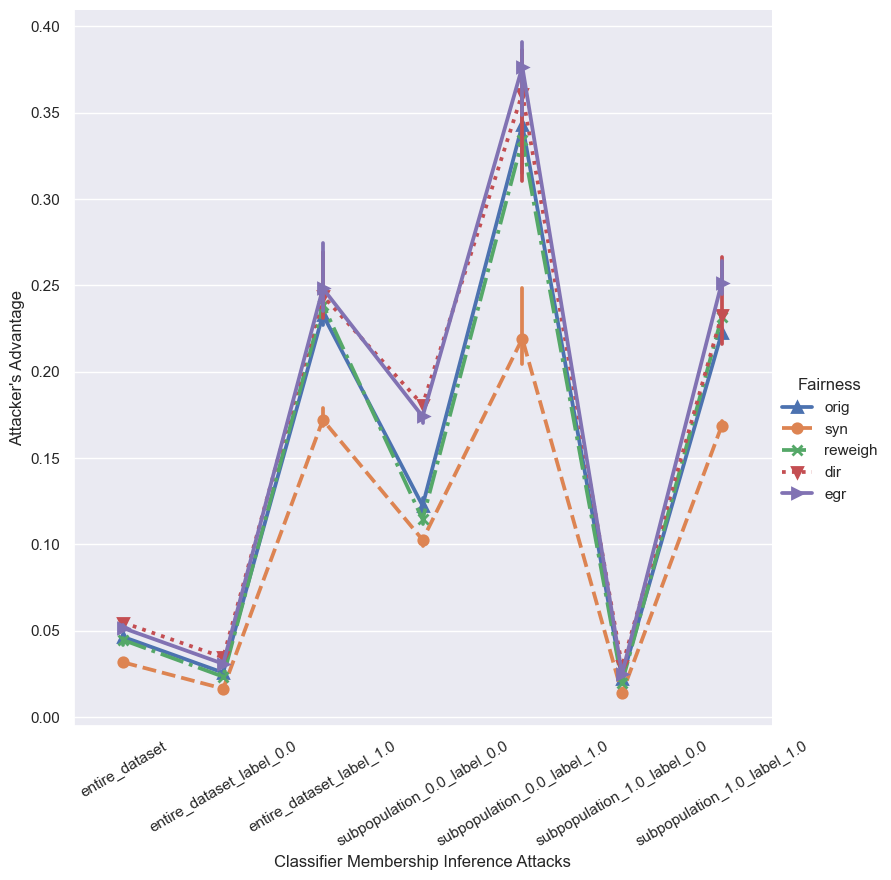

In [57]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


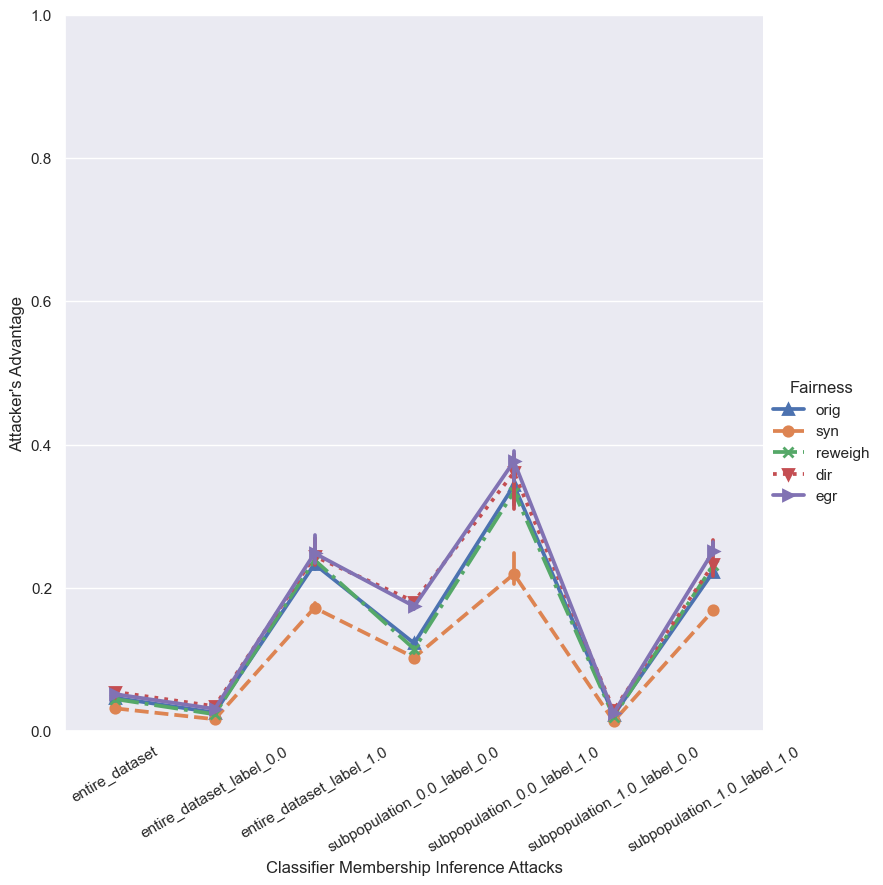

In [58]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [59]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.044047,0.024933,0.226890,0.113675,0.315223,0.021310,0.221823
1,0.047608,0.026177,0.236182,0.126904,0.357038,0.022915,0.222976
2,0.047608,0.026177,0.236182,0.126904,0.357038,0.022915,0.222976


In [60]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [61]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.04642101460494393,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.025762133517575243,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.23308444034245013,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.12249416054886013,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.34309965298683304,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.0223802269704656,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.2225917628963412}

In [62]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.046421,0.025762,0.233084,0.122494,0.343100,0.022380,0.222592
syn,0.031713,0.016503,0.172178,0.102688,0.219278,0.013762,0.168836
dir,0.054730,0.034637,0.243983,0.180890,0.361165,0.029440,0.232967
rew,0.044615,0.023425,0.238921,0.114515,0.334074,0.020069,0.231764
egr,0.051530,0.030902,0.248311,0.174139,0.376656,0.025087,0.251633


<Axes: xlabel='Classifier MIA Attacks'>

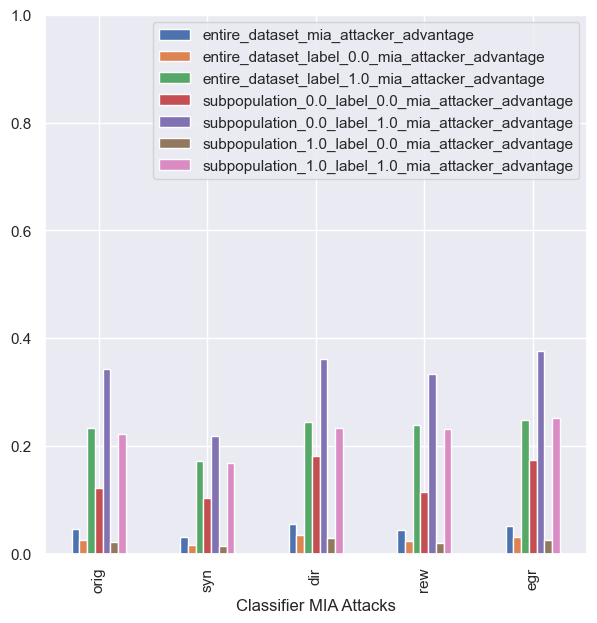

In [63]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [64]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [65]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5118457759087314],
 ['orig', 'entire_dataset', 0.5127260687828498],
 ['orig', 'entire_dataset', 0.5127260687828498],
 ['orig', 'entire_dataset_label_0.0', 0.5057430484722161],
 ['orig', 'entire_dataset_label_0.0', 0.5071218730526128],
 ['orig', 'entire_dataset_label_0.0', 0.5071218730526128],
 ['orig', 'entire_dataset_label_1.0', 0.6755952380952381],
 ['orig', 'entire_dataset_label_1.0', 0.6311360448807853],
 ['orig', 'entire_dataset_label_1.0', 0.6311360448807853],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5106082036775106],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5530973451327434],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5530973451327434],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6851851851851851],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6923076923076923],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6923076923076923],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5057698496620845],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5061643521701269],
 ['

In [66]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.511846
1,orig,entire_dataset,0.512726
2,orig,entire_dataset,0.512726
3,orig,entire_dataset_label_0.0,0.505743
4,orig,entire_dataset_label_0.0,0.507122
...,...,...,...
100,egr,subpopulation_1.0_label_0.0,0.507025
101,egr,subpopulation_1.0_label_0.0,0.507025
102,egr,subpopulation_1.0_label_1.0,0.633838
103,egr,subpopulation_1.0_label_1.0,0.642932


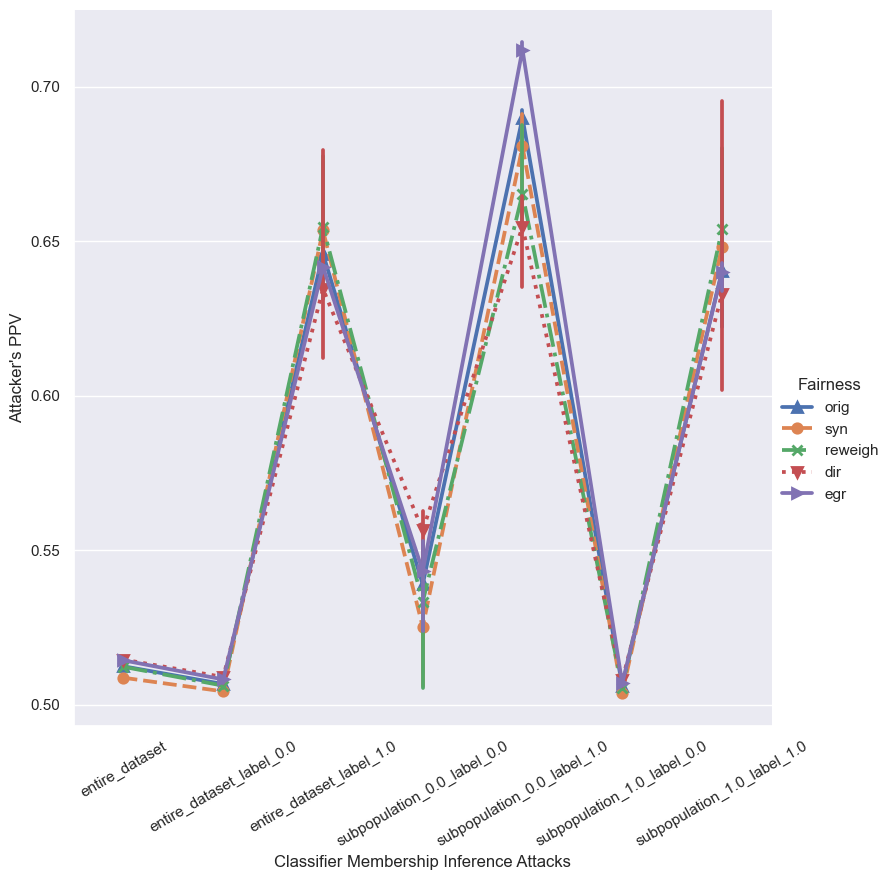

In [67]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [68]:
import pandas as pd

In [69]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,1.0,281.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25832,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25833,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25834,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [70]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.865885
1.0  1.0       0.088133
0.0  0.0       0.034564
0.0  1.0       0.011418
Name: proportion, dtype: float64

In [71]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25831,1.0,281.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25832,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25833,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25834,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## DT Accuracy

In [72]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

[INFO]: training decision tree
Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       449
         1.0       0.00      0.00      0.00         0

    accuracy                           0.97       449
   macro avg       0.50      0.48      0.49       449
weighted avg       1.00      0.97      0.98       449

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.73      0.84       146

    accuracy                           0.73       146
   macro avg       0.50      0.36      0.42       146
weighted avg       1.00      0.73      0.84       146

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     11192
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99     1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'train_0_0': 0.9665924276169265,
 'train_0_1': 0.726027397260274,
 'train_1_0': 0.98668691922802,
 'train_1_1': 0.6419098143236074,
 'test_0_0': 0.8671171171171171,
 'test_0_1': 0.3624161073825503,
 'test_1_0': 0.9638608104481617,
 'test_1_1': 0.43019197207678883}

In [73]:
train_test_egr

{'train_0_0': 0.9732739420935412,
 'train_0_1': 0.6712328767123288,
 'train_1_0': 0.983470335954253,
 'train_1_1': 0.6613616268788682,
 'test_0_0': 0.8648648648648649,
 'test_0_1': 0.3221476510067114,
 'test_1_0': 0.9617139279005278,
 'test_1_1': 0.4493891797556719}